<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Frequency-model-:-Gamma-distribution" data-toc-modified-id="Frequency-model-:-Gamma-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Frequency model : Gamma distribution</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Evaluation</a></span></li></ul></div>

# Load the libraries

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import sklearn
import scipy
import matplotlib.pyplot as plt
sns.set()


SEED = 100
pd.set_option('max_columns',100)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly
%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
seaborn  0.11.0
sklearn  0.23.1
pandas   1.1.0
json     2.0.9
numpy    1.18.4
scipy    1.4.1
autopep8 1.5.2



# Load the data

In [12]:
df = pd.read_csv('../data/processed/clean_data.csv.zip', compression='zip')
print(df.shape)
df.head(2).append(df.tail(2))

(100000, 15)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
1,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
99998,0,0.90,C,7,9,44,50,B1,Regular,191,R24,0.0,0.0,0.0,0.0
99999,0,0.90,E,4,12,53,50,B1,Regular,4116,R24,0.0,0.0,0.0,0.0


In [13]:
X = scipy.sparse.load_npz("../data/processed/X.npz")

In [14]:
df.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
1,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0


In [15]:
np.array(X[0].todense())[0][-5:] # last elements of first row

array([ 0.        ,  1.        ,  0.        ,  0.69864446, 50.        ])

In [16]:
with open("../data/processed/features.json") as fi:
    json_features = json.load(fi)

In [17]:
json_features.keys()

dict_keys(['cols_ohe_before', 'cols_kbin', 'cols_log_scale', 'cols_pass', 'feature_names_before', 'feature_names_after', 'desc'])

# Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=SEED)

target = ['Frequency']

y_train = df_train[target].to_numpy().ravel()
y_test = df_test[target].to_numpy().ravel()

df_train.shape, df_test.shape, X_train.shape, X_test.shape

((75000, 15), (25000, 15), (75000, 71), (25000, 71))

# Frequency model : Gamma distribution
- We have created new feature `AvgClaimAmount` which approximately follows Gamma Distribution.
- We take only ClaimAmount > 0 as the Gamma distribution has support on (0,infinity) , not [0,infinity) .

- We use `sample_weight = ClaimNb` to account for policies that contain more than one claim.

In [28]:
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_tweedie_deviance

In [23]:
df.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
1,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0


In [33]:
mask_train = (df_train["ClaimAmount"] > 0).to_numpy().ravel()
mask_test = (df_test["ClaimAmount"] > 0).to_numpy().ravel()

glm_sev = GammaRegressor(alpha=10., max_iter=10_000)

glm_sev.fit(
    X_train[mask_train],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

GammaRegressor(alpha=10.0, max_iter=10000)

In [34]:
# glm_sev.score?

In [36]:
tr_D2 = glm_sev.score(X_train[mask_train],
                      df_train.loc[mask_train, 'AvgClaimAmount'],
                      sample_weight=df_train.loc[mask_train, 'ClaimNb'])

tx_D2 = glm_sev.score(X_test[mask_test],
                      df_test.loc[mask_test, 'AvgClaimAmount'],
                      sample_weight=df_test.loc[mask_test, 'ClaimNb'])


tr_preds = glm_sev.predict(X_train)
tx_preds = glm_sev.predict(X_test)

tr_mae = mean_absolute_error(y_train,tr_preds)
tx_mae = mean_absolute_error(y_test,tx_preds)

tr_mse = mean_squared_error(y_train, tr_preds)
tx_mse = mean_squared_error(y_test,tx_preds)


df_eval_sev = pd.DataFrame(
{'train': [tr_D2, tr_mae, tr_mse],
'test': [tx_D2, tx_mae, tx_mse]})

df_eval_sev.index = ['D2','mean_absolute_error','mean_squared_error']
df_eval_sev

,train,test
D2,3.638157e-03,-4.747382e-04
mean_absolute_error,1.869329e+03,1.868959e+03
mean_squared_error,3.496896e+06,3.495441e+06


In [38]:
# NOTE
note = """
Here the D-squared value for test is too bad. This is because when doing train
modelling we have masked values with claim amount greater than 0, not zero.

The test results are for average claims per claim.
We can not use this model to predict the average claim amount per policy.


"""

In [39]:
print("Mean AvgClaim Amount per policy:              %.2f "
      % df_train["AvgClaimAmount"].mean())
print("Mean AvgClaim Amount | NbClaim > 0:           %.2f"
      % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean())
print("Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
      % glm_sev.predict(X_train).mean())

Mean AvgClaim Amount per policy:              88.51 
Mean AvgClaim Amount | NbClaim > 0:           1879.52
Predicted Mean AvgClaim Amount | NbClaim > 0: 1869.48


# Model Evaluation

In [57]:
feature = 'DrivAge'
df_ = df_train
preds = tr_preds

observed = 'AvgClaimAmount' # Frequency for freq-modelling
weight = 'ClaimNb'

dfx = df_.loc[:, [feature, weight]].copy()
dfx["observed"]  = df_[observed] * df_[weight]
dfx["predicted"] = preds * df_[weight]

dfx = (
    dfx.groupby([feature])[[weight, "observed", "predicted"]]
    .sum()
    .assign(observed=lambda x: x["observed"] / x[weight])
    .assign(predicted=lambda x: x["predicted"] / x[weight])
    .dropna(how='any')
)

dfx.head()

,ClaimNb,observed,predicted
DrivAge,,,
18,12,885.574167,1974.728947
19,48,3429.702083,1967.724569
20,49,3223.072041,1996.077413
21,47,1693.798723,1998.675510
22,62,2423.892258,1982.059970


y_max = 7352.7015


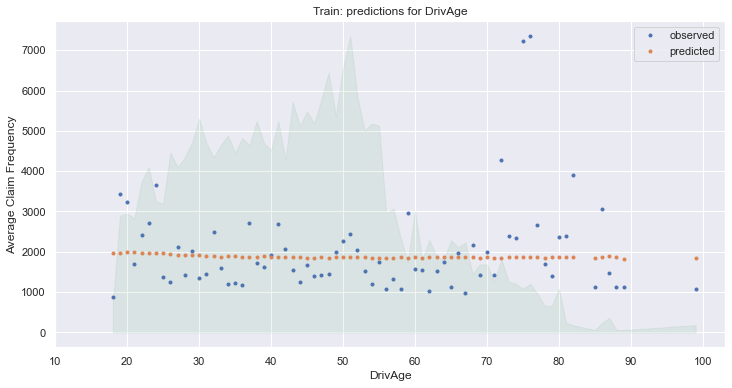

In [59]:
fig,ax = plt.subplots(figsize=(12,6))

ax = dfx.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
plt.ylabel('Average Claim Frequency')

# fill feature distribution
y_max = dfx.loc[:, ["observed", "predicted"]].values.max()
print(f"y_max = {y_max:.4f}")
p2 = ax.fill_between(
    dfx.index,
    0,
    y_max * dfx[weight] / dfx[weight].values.max()  , # fill between 0 to this.
    color="g",
    alpha=0.1,
)

plt.xticks(range(10,110,10))
plt.title(f"Train: predictions for {feature}");

In [53]:
_ = """
Here, The predicted line is almost flat.
We can see that driver age (DrivAge) has not much impact on Average Claim Frequency.


"""